In [19]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List

%matplotlib notebook

We have for the non-adaptive method that:
\begin{align*}
x(t+H) &= R_{n,m} + c_mh_n^{2m} + O(h_n^{2m+2}) \\
c_mh_n^{2m} &= \frac{R_{n,m} - R_{n-1,m}}{[n/(n-1)]^{2m} - 1}
\end{align*}
so
\begin{equation*}
R_{n,m+1} = R_{n,m} + \frac{R_{n,m} - R_{n-1,m}}{[n/(n-1)]^{2m} - 1}
\end{equation*}

In [87]:
def mod_mid(df: Callable, H: float, n: int, x0: List):
    h = H/n
    r1 = x0 + 0.5*h*df(x0)
    r2 = x0 + h*df(r1)
    for i in range(n-1):
        r1 += h*df(r2)
        r2 += h*df(r1)  
    return 0.5*(r1 + r2 + 0.5*h*df(r2))

In [88]:
def R(df: Callable, H: float, n: int, m: int, x0: List):
    if m == 1:
        return (mod_mid(df, H, n, x0), np.inf*np.ones(x0.shape))
    else:
        R_n1m1 = R(df, H, n-1, m-1, x0)[0]
        R_nm1 = R(df, H, n, m-1, x0)[0]
        error = (R_nm1 - R_n1m1) / (np.power(n/(n-1), 2*(m-1)) - 1)
        return (R_nm1 + error, error)

In [187]:
def x(df: Callable, H: float, x0: List, delta=1e-10, max_n=np.inf):
    n = 1
    r, error = R(df, H, n, n, x0)
    
    while (abs(error) > H*delta).any():
        n += 1
        r, error = R(df, H, n, n, x0)
        if n > max_n or (abs(error) > 1e8).any():
            return None
    return r

In [188]:
def adaptive_x(df, H, x0, delta=1e-10, max_n=8):
    h = H
    next_val = x(df, h, x0, delta=delta, max_n=max_n)
    while next_val is None:
        h = h / 2
        next_val = x(df, h, x0, delta=delta, max_n=max_n)
    return (next_val, h)

Example: $x'(t) = x$

(143, 2)


<IPython.core.display.Javascript object>


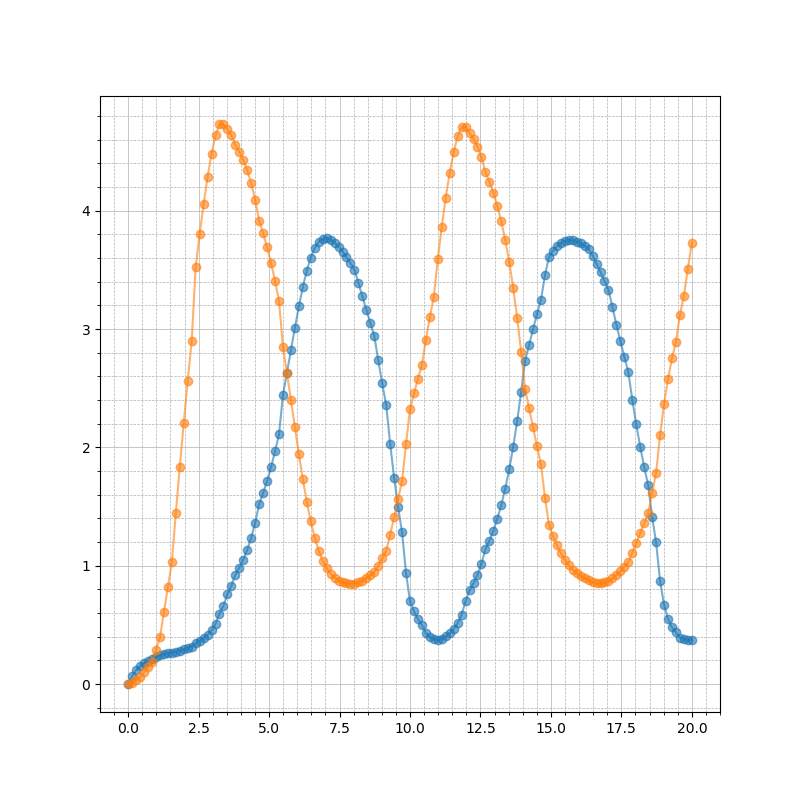

In [192]:
def df(vec):
    a = 1
    b = 3
    dx = 1 - (b +1)*vec[0] + a*vec[0]**2 * vec[1]
    dy = b*vec[0] - a*vec[0]**2 * vec[1]
    return np.array([dx, dy])

a = 0
b = 20
N = 50

t = np.linspace(a, b, N)
x_vals = np.zeros(N)
x0 = np.array([0, 0])
x_vals = [x0]

N2 = 1
for _ in range(N2):
    h_left = (b-a)/N2
    while h_left > 0:
        next_step = adaptive_x(df, h_left, x_vals[-1], delta=1e-10)
        x_vals.append(next_step[0])
        h_left -= next_step[1]
x_vals = np.array(x_vals)
print(x_vals.shape)

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()
ax.plot(np.linspace(a, b, x_vals.shape[0]), x_vals[:, 0], '-o', alpha=0.6)
ax.plot(np.linspace(a, b, x_vals.shape[0]), x_vals[:, 1], '-o', alpha=0.6)
#ax.plot(t, np.exp(t), alpha=0.5)

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')